## Import Libraries

In [116]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
# Ingnore some warnings to better display on Jupyter NB
import warnings
warnings.filterwarnings('ignore')

In [117]:
tf.__version__

'2.4.1'

## Create Dataset

In [118]:
# Define some constant parameters
IMG_WIDTH = 30
IMG_HEIGHT = 30
EPOCHS = 50

In [119]:
# Create an Image Generator
img_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_data_dir = os.path.dirname('Train-Data/')
# Create train dataset with ImageGenerator from local directory
train_ds = img_gen.flow_from_directory(
    directory=train_data_dir,
    subset='training',
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    interpolation='bilinear',
    batch_size=48)

# Create validation dataset with ImageGenerator from local directory
val_ds = img_gen.flow_from_directory(
    directory=train_data_dir,
    subset='validation',
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    interpolation='bilinear',
    batch_size=16)

Found 56529 images belonging to 36 classes.
Found 14116 images belonging to 36 classes.


In [120]:
print('Shape of one batch of data:\n', train_ds[0][0].shape, '\n')
print('Shape of one batch of labels:\n', train_ds[0][1].shape, '\n')

Shape of one batch of data:
 (48, 30, 30, 1) 

Shape of one batch of labels:
 (48, 36) 



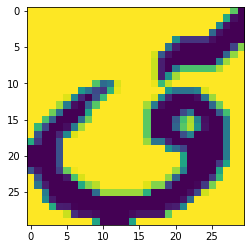

In [121]:
# Show one sample of data
img = train_ds[0][0][4]
plt.imshow(img)

## Build Model

In [122]:
# Define CNN + FullyConnectedNetwork Model
def OCR_Net(input_shape: tuple):
    model = keras.models.Sequential([
    keras.layers.Conv2D(64, 5, input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(128, 5),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.ReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(1024),
    keras.layers.ReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(36),
    keras.layers.Softmax()])
    # Compile Model
    model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics='accuracy')
    return model

In [123]:
input_shape = (IMG_WIDTH, IMG_HEIGHT, 1)
OCR_model = OCR_Net(input_shape)
OCR_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 26, 26, 64)        1664      
_________________________________________________________________
batch_normalization_64 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
re_lu_48 (ReLU)              (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 9, 9, 128)         204928    
_________________________________________________________________
batch_normalization_65 (Batc (None, 9, 9, 128)       

## Training Model

In [124]:
# Create logs directory
if not os.path.exists('logs/'):
    os.mkdir('logs/')

# Define callbacks
# Early Stopping prevents from overfitting
earlystopping_cb = keras.callbacks.EarlyStopping(patience=3)
# Save weights of model while training
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='logs/',
                                              save_best_only=True,
                                              save_weights_only=True)
# Fit model to train data
model_history = OCR_model.fit(train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[earlystopping_cb, checkpoint_cb])

Epoch 1/20
1178/1178 [==============================] - 76s 64ms/step - loss: 0.7272 - accuracy: 0.7903 - val_loss: 0.3623 - val_accuracy: 0.8850
Epoch 2/20
1178/1178 [==============================] - 70s 59ms/step - loss: 0.2204 - accuracy: 0.9301 - val_loss: 0.2964 - val_accuracy: 0.9065
Epoch 3/20
1178/1178 [==============================] - 32s 27ms/step - loss: 0.1649 - accuracy: 0.9454 - val_loss: 0.4429 - val_accuracy: 0.8669
Epoch 4/20
1178/1178 [==============================] - 32s 27ms/step - loss: 0.1245 - accuracy: 0.9595 - val_loss: 0.1771 - val_accuracy: 0.9438
Epoch 5/20
1178/1178 [==============================] - 31s 26ms/step - loss: 0.1087 - accuracy: 0.9647 - val_loss: 0.1822 - val_accuracy: 0.9418
Epoch 6/20
1178/1178 [==============================] - 33s 28ms/step - loss: 0.0932 - accuracy: 0.9684 - val_loss: 0.3084 - val_accuracy: 0.9003
Epoch 7/20
1178/1178 [==============================] - 34s 29ms/step - loss: 0.0813 - accuracy: 0.9729 - val_loss: 0.2848 -

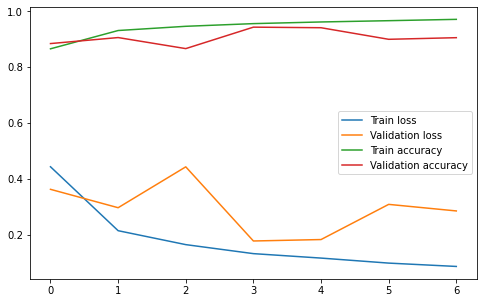

In [128]:
# Mean Squared Error for train and validation data
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(model_history.history["loss"], label="Train loss")
ax.plot(model_history.history["val_loss"], label="Validation loss")
ax.plot(model_history.history["accuracy"], label="Train accuracy")
ax.plot(model_history.history["val_accuracy"], label="Validation accuracy")
ax.legend()

## Evaluation Model

In [129]:
# Create test dataset from images saved in 'Test-Data' folder
img_gen_ = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_dir = os.path.dirname('Test-Data/')
test_ds = img_gen_.flow_from_directory(
    directory=test_data_dir,
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    interpolation='bilinear',
    batch_size=48)

# Evaluation accuracy of model
loss, acc = OCR_model.evaluate(test_ds, verbose=1)
print(f"Untrained model, accuracy: {100*acc:5.2f}%")

Found 17706 images belonging to 36 classes.
369/369 [==============================] - 7s 19ms/step - loss: 0.2903 - accuracy: 0.9064
Untrained model, accuracy: 90.64%


In [137]:
class_values = ["ا",
    "ب",
    "پ",
    "ت",
    "ث",
    "ج",
    "چ",
    "ح",
    "خ",
    "د",
    "ذ",
    "ر",
    "ز",
    "ژ",
    "س",
    "ش",
    "ص",
    "ض",
    "ط",
    "ظ",
    "ع",
    "غ",
    "ف",
    "ق",
    "ک",
    "گ",
    "ل",
    "م",
    "ن",
    "و",
    "ه",
    "ی",
    "ئـ",
    "آ",
    "هـ",
    "ـه"]

The predicted letter is:  ئـ


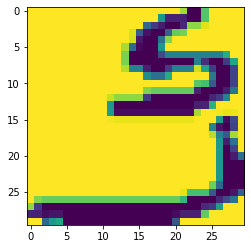

In [138]:
# This fuction is defined to prediction and letter indices
def get_letter(pred):
    for letter, value in test_ds.class_indices.items():
        if pred == value:
            return int(letter)
# Predict one sample of data
sample = test_ds[0][0][20]
pred = OCR_model.predict(sample.reshape((1, 30, 30, 1))).round(3).argmax()
print("The predicted letter is: ", class_values[get_letter(pred)])
plt.imshow(sample)